In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import seaborn as sns


In [2]:
LOW_QUANTILE = 0.25
HIGH_QUANTILE = 0.2501

# Create a Folder to Store the Results
import os

if not os.path.exists("Results" + "_" + str(LOW_QUANTILE) + "_" + str(HIGH_QUANTILE)):
    os.mkdir("Results" + "_" + str(LOW_QUANTILE) + "_" + str(HIGH_QUANTILE))
    
save_path = "Results" + "_" + str(LOW_QUANTILE) + "_" + str(HIGH_QUANTILE) + "/"

## Data

### mRNA Expression Data

In [3]:
mRNA_df = pd.read_csv('Depmap Melanoma mRNA.csv')
mRNA_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [4]:
full_mRNA_df = pd.read_csv('Depmap Pancancer mRNA.csv')
full_mRNA_df.drop(['Unnamed: 0'], axis=1, inplace=True)

### Gene Dependency Data

In [5]:
# SWAP THIS TO RUN WITH GENE EFFECT
dependency_df = pd.read_csv('Depmap Melanoma Gene Effect.csv')
dependency_df.drop(['Unnamed: 0'], axis=1, inplace=True)

### Cell Lines Data

In [6]:
cell_df = pd.read_csv('Depmap Melanoma Cells.csv')
cell_df.drop(['Unnamed: 0'], axis=1, inplace=True)

### VIP Data (VIP_M DF & VIP_U DF)

In [7]:
# Gene Dependency (4-vars) VIP Scores
vip_df = pd.read_csv(r'C:\Users\commo\OneDrive - University of Virginia\School\STEM\BME\BME 4700 - Systems Bioengineering\CCLE Chromatin Analysis\Models\Multivariable PLSR\Gene Dependency\VIP Scores\Gene Dependency (4-vars) VIP Scores.csv')
print(vip_df.shape)
vip_df.head(5)

(498, 5)


,Gene,M-TM,T-TM-TN,N-TN-NU,U-NU
0,ACTB,-1.565552,-1.489925,1.344195,1.524378
1,ACTL6A,-1.213636,-1.073693,1.061273,1.202825
2,ACTL6B,0.528281,0.517434,-0.481300,-0.518155
3,AKAP8,0.667250,0.766280,-0.584709,-0.621358
4,AKAP8L,1.537476,1.540888,-1.339207,-1.484803


##### VIP-M

In [8]:
# VIP-M = Genes with M-TM Score > 1.0 & U-NU < -1.0
vip_m = vip_df[(vip_df['M-TM'] > 1.0) & (vip_df['U-NU'] < -1.0)]
print(vip_m.shape)
vip_m.head(5)

(78, 5)


,Gene,M-TM,T-TM-TN,N-TN-NU,U-NU
4,AKAP8L,1.537476,1.540888,-1.339207,-1.484803
19,ASF1A,1.273099,1.353588,-1.087987,-1.206153
38,BCOR,1.084413,1.113473,-0.989359,-1.052571
40,BMI1,1.335860,1.327599,-1.463934,-1.374021
41,BPTF,1.787900,1.655963,-1.611635,-1.769182


##### VIP-U

In [9]:
# VIP-U = Genes with M-TM Score < -1.0 & U-NU > 1.0
vip_u = vip_df[(vip_df['M-TM'] < -1.0) & (vip_df['U-NU'] > 1.0)]
print(vip_u.shape)
vip_u.head(5)

(88, 5)


,Gene,M-TM,T-TM-TN,N-TN-NU,U-NU
0,ACTB,-1.565552,-1.489925,1.344195,1.524378
1,ACTL6A,-1.213636,-1.073693,1.061273,1.202825
6,APBB1,-1.024399,-0.891535,0.943952,1.029994
8,APP,-1.023702,1.063689,1.292265,1.095916
12,ARID3A,-1.143215,-0.998690,1.059495,1.150287


## Analysis

### Validating Assumptions / mRNA Quartiles

#### Normality Test (Shapiro-Wilk Test) for mRNA Expression and Gene Dependency

In [10]:
# Shapiro-Wilk Test for Normality for All Genes in Gene mRNA Expression Data
# Interpretation: p-value < 0.05, therefore  mRNA data is not normally distributed
results = []
for gene in mRNA_df.columns[1:]:
    results.append((gene,stats.shapiro(mRNA_df[gene])[0],stats.shapiro(mRNA_df[gene])[1]))
    
shapiro_df = pd.DataFrame(results, columns=['Gene','W-Stat','p-value'])
print(shapiro_df.shape)
print(mRNA_df.shape)
print('number of genes that are normally distributed: ', len(shapiro_df[shapiro_df['p-value'] > 0.05]))
    

c:\Users\commo\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1797: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


(19193, 3)
(60, 19194)
number of genes that are normally distributed:  7925


In [11]:
# Shapiro-Wilk Test for Normality for All Genes in Gene Dependency Data
# Interpretation: p-value < 0.05, therefore  dependency data is not normally distributed

results = []
for gene in dependency_df.columns[1:]:
    results.append((gene,stats.shapiro(dependency_df[gene])[0],stats.shapiro(dependency_df[gene])[1]))
    
shapiro_df = pd.DataFrame(results, columns=['Gene','W-Stat','p-value'])
print(shapiro_df.shape)
print(dependency_df.shape)
print('number of genes that are normally distributed: ', len(shapiro_df[shapiro_df['p-value'] > 0.05]))

(17453, 3)
(60, 17454)
number of genes that are normally distributed:  12279


#### mRNA Quartiles (Pancancer mRNA & Melanoma mRNA)

##### VIP-M mRNA Subset

In [12]:
# Subset mRNA for VIP-M Genes
mRNA_vip_m_df = mRNA_df[vip_m['Gene']]
print(mRNA_vip_m_df.shape)
print(vip_m.shape)

# Calulcate the all the quantiles for each gene in the mRNA data
m_mRNA_quantiles = mRNA_vip_m_df.quantile([LOW_QUANTILE, 0.5, HIGH_QUANTILE])

# Save
m_mRNA_quantiles.to_csv(save_path + '/Melanoma mRNA VIP-M Quantiles.csv')

m_mRNA_quantiles.head(5)

(60, 78)
(78, 5)


,AKAP8L,ASF1A,BCOR,BMI1,BPTF,BRD1,BRD4,CBX5,CBX8,CDYL,...,TAF5L,TET2,TNP1,TRIM24,TRIM28,UHRF2,WDR82,XBP1,ZBTB7B,ZMYND8
0.2500,4.799468,3.114294,3.591260,4.391286,4.246386,3.043455,4.170553,4.123494,2.568376,3.561323,...,3.680303,1.268996,0.0,3.089401,8.048368,3.958609,5.311191,6.043930,3.019946,4.481559
0.5000,5.015247,3.718088,4.042627,4.728709,4.654777,3.611761,4.473449,4.430620,2.868868,3.892379,...,4.017392,1.769672,0.0,3.351687,8.525503,4.354316,5.606120,6.307943,3.441590,4.972987
0.2501,4.799533,3.114492,3.591281,4.391295,4.246494,3.043641,4.170859,4.123553,2.569274,3.561366,...,3.680410,1.269138,0.0,3.089714,8.049004,3.958637,5.311367,6.044050,3.020275,4.482342


In [13]:
# Subset pan mRNA for VIP-M Genes
full_mRNA_vip_m_df = full_mRNA_df[vip_m['Gene']]
print(full_mRNA_vip_m_df.shape)
print(vip_m.shape)

# Calulcate the all the quantiles for each gene in the pan mRNA data
m_full_mRNA_quantiles = full_mRNA_vip_m_df.quantile([LOW_QUANTILE, 0.5, HIGH_QUANTILE])

# Save
m_full_mRNA_quantiles.to_csv(save_path + '/Pancancer mRNA VIP-M Quantiles.csv')

m_full_mRNA_quantiles.head(5)

(1407, 78)
(78, 5)


,AKAP8L,ASF1A,BCOR,BMI1,BPTF,BRD1,BRD4,CBX5,CBX8,CDYL,...,TAF5L,TET2,TNP1,TRIM24,TRIM28,UHRF2,WDR82,XBP1,ZBTB7B,ZMYND8
0.2500,4.819924,3.442280,3.373648,4.281327,4.356848,3.329841,3.993674,4.276496,2.185867,3.467931,...,3.609991,1.669027,0.0,2.854993,8.131728,3.827311,5.056365,5.692650,3.338424,3.651912
0.5000,5.148934,3.972693,3.899176,4.807870,4.827819,3.750607,4.475085,4.883132,2.666757,3.879706,...,4.004501,2.134221,0.0,3.418190,8.655602,4.357552,5.546277,6.271089,3.949535,4.266787
0.2501,4.819995,3.442280,3.373844,4.281640,4.356848,3.330043,3.993929,4.276706,2.185867,3.468115,...,3.609991,1.669027,0.0,2.855273,8.131880,3.827454,5.056914,5.692885,3.338625,3.652235


##### VIP-U mRNA Subset

In [14]:
# Inner Join of vip_u and columns in mRNA_df
vip_u_genes = vip_u['Gene'].tolist()
mRNA_genes = mRNA_df.columns[1:].tolist()
intersection = list(set(vip_u_genes).intersection(mRNA_genes))

# Subset mRNA for VIP-M Genes
mRNA_vip_u_df = mRNA_df[intersection]
print(mRNA_vip_u_df.shape)
print(vip_u.shape)

# Calulcate the all the quantiles for each gene in the mRNA data
u_mRNA_quantiles = mRNA_vip_u_df.quantile([LOW_QUANTILE,0.5,HIGH_QUANTILE])

# Save
u_mRNA_quantiles.to_csv(save_path + '/Melanoma mRNA VIP-U Quantiles.csv')

u_mRNA_quantiles.head(5)

(60, 87)
(88, 5)


,PAXBP1,HSPBAP1,BCL6,SUDS3,ACTL6A,DDX11,TAF10,MYOD1,HIRIP3,GATAD2A,...,SMARCA1,SMYD5,SAFB,BRD7,ZBTB33,TAF9,WDR5B,KDM4D,KDM4A,APBB1
0.2500,3.652771,2.855986,2.949202,3.636025,6.241453,4.161281,6.244783,0.0,4.388129,4.257472,...,3.602670,4.175514,5.301379,5.041769,2.970495,6.255189,1.980938,0.750563,4.052021,3.866401
0.5000,4.037383,3.180228,3.545833,3.979567,6.487839,4.768447,6.846053,0.0,4.698212,5.086385,...,4.407333,4.461719,6.009545,5.219342,3.510328,6.604425,2.250962,0.959765,4.266992,4.291309
0.2501,3.652805,2.856033,2.949626,3.636128,6.241508,4.161314,6.244853,0.0,4.388309,4.257709,...,3.603010,4.175590,5.301496,5.041769,2.970935,6.255312,1.980960,0.750716,4.052067,3.866483


In [15]:
# Subset mRNA for VIP-M Genes
full_mRNA_vip_u_df = full_mRNA_df[intersection]
print(full_mRNA_vip_u_df.shape)
print(vip_u.shape)

# Calulcate the all the quantiles for each gene in the mRNA data
u_full_mRNA_quantiles = full_mRNA_vip_u_df.quantile([LOW_QUANTILE,0.5,HIGH_QUANTILE])

# Save
u_full_mRNA_quantiles.to_csv(save_path + '/Pancancer mRNA VIP-U Quantiles.csv')

u_full_mRNA_quantiles.head(5)

(1407, 87)
(88, 5)


,PAXBP1,HSPBAP1,BCL6,SUDS3,ACTL6A,DDX11,TAF10,MYOD1,HIRIP3,GATAD2A,...,SMARCA1,SMYD5,SAFB,BRD7,ZBTB33,TAF9,WDR5B,KDM4D,KDM4A,APBB1
0.2500,3.801676,2.336283,2.297191,3.887038,6.208186,4.347666,6.101923,0.0,4.095924,4.299391,...,1.790772,4.100557,5.541328,5.220716,2.933573,5.980596,1.853994,0.565597,3.966707,0.989134
0.5000,4.346957,2.746313,3.198494,4.259272,6.593204,5.164706,6.615446,0.0,4.609991,4.862451,...,4.152183,4.500165,6.057667,5.619413,3.378512,6.396262,2.189034,0.871844,4.379898,2.992768
0.2501,3.801821,2.336283,2.297603,3.887175,6.208213,4.347666,6.102130,0.0,4.096161,4.299597,...,1.790772,4.100675,5.541677,5.221151,2.933573,5.981077,1.854555,0.565597,3.966837,0.990156


### T-Tests Between mRNA Quartiles

#### VIP-M mRNA Quartile T-Tests

In [53]:
results = []
m_gene_groups = pd.DataFrame()

for gene in vip_m['Gene']:
    # Index by gene column and then quantile row index
    low_expression = m_full_mRNA_quantiles[gene][LOW_QUANTILE]
    
    # Testing for > 25th percentile or < 75th percentile
    high_expression = m_full_mRNA_quantiles[gene][HIGH_QUANTILE]
    
    # Create a filter and then index by the gene column
    low_expression_cells = mRNA_df[mRNA_df[gene] <= low_expression][['Cell Line',gene]]
    high_expression_cells = mRNA_df[mRNA_df[gene] > high_expression][['Cell Line',gene]]
    
    # T-Test of Gene mRNA Levels in Low and High Expression Cells
    ttest = stats.ttest_ind(low_expression_cells[gene], high_expression_cells[gene],  alternative = 'two-sided')
    
    # Append the results to the results list
    # Format: (Gene, Low Samples, Low Expression Mean, High Samples High Expression Mean, T-Stat, P-Value)
    results.append((gene, len(low_expression_cells), low_expression_cells[gene].mean(), len(high_expression_cells), high_expression_cells[gene].mean(), ttest[0], ttest[1]))
    
    # Add a column to the low expression cells called "Group" and assign it the value "low"
    low_expression_cells['Group'] = 'low'
    high_expression_cells['Group'] = 'high'
    
    # Sort the cells by cell line so that they are in the same order as the gene_groups dataframe
    expression = pd.concat([low_expression_cells, high_expression_cells])
    expression.sort_values(by=['Cell Line'], inplace=True)
    
    # Append the low and high expression cells to the gene_groups list
    m_gene_groups = pd.concat([m_gene_groups, expression['Group']], axis=1)
    m_gene_groups.rename(columns={'Group': gene}, inplace=True)
    
    
    
m_ttest_df = pd.DataFrame(results, columns=['Gene','Low Samples','Low Expression Mean','High Samples','High Expression Mean','T-Stat','P-Value'])
print(m_ttest_df.shape)
print("Number of Genes with Significant Difference in Expression: ", len(m_ttest_df[m_ttest_df['P-Value'] < 0.05]))
m_ttest_df.sort_values(by=['Gene'], inplace=True)
m_ttest_df.reset_index(inplace=True, drop=True)
m_ttest_df.head(5)
    


C:\Users\commo\AppData\Local\Temp\ipykernel_44772\2731502266.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ttest = stats.ttest_ind(low_expression_cells[gene], high_expression_cells[gene],  alternative = 'two-sided')
c:\Users\commo\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:1253: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\commo\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:1253: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


(78, 7)
Number of Genes with Significant Difference in Expression:  75


,Gene,Low Samples,Low Expression Mean,High Samples,High Expression Mean,T-Stat,P-Value
0,AKAP8L,17,4.570931,43,5.210672,-8.111976,3.976650e-11
1,ASF1A,22,2.925619,38,4.037113,-11.621782,8.847772e-17
2,BCOR,10,3.110556,50,4.198643,-7.803730,1.307134e-10
3,BMI1,10,3.872629,50,4.804393,-8.370477,1.470465e-11
4,BPTF,20,4.048457,40,4.821935,-9.156265,7.330835e-13


In [17]:
print(m_gene_groups.shape)
# where m_genes is null
print(m_gene_groups.loc[:,m_gene_groups.isnull().any(axis=0)].columns)
m_gene_groups.head(5)


(60, 78)
Index([], dtype='object')


,AKAP8L,ASF1A,BCOR,BMI1,BPTF,BRD1,BRD4,CBX5,CBX8,CDYL,...,TAF5L,TET2,TNP1,TRIM24,TRIM28,UHRF2,WDR82,XBP1,ZBTB7B,ZMYND8
0,high,high,high,low,high,high,high,high,high,high,...,high,high,low,high,high,high,high,high,high,high
1,high,high,high,high,high,low,high,high,high,low,...,high,high,low,high,high,high,high,low,high,high
2,high,high,high,high,low,low,high,high,high,low,...,high,low,low,high,high,high,high,high,low,high
3,high,high,low,high,low,low,high,high,high,low,...,high,low,low,low,high,high,high,high,high,high
4,high,high,high,high,low,low,high,low,high,low,...,high,low,low,high,low,high,high,high,low,high


In [18]:
# Write to CSV
m_ttest_df.sort_values(by=['Low Samples','High Samples'], ascending=[False,True], inplace=True)
m_ttest_df.reset_index(drop=True, inplace=True)
m_ttest_df.to_csv(save_path + 'M mRNA T-Test Results( less ' + str(LOW_QUANTILE) + ' greater ' + str(HIGH_QUANTILE) + ' ).csv')

#### VIP-U mRNA Quartile T-Tests

In [52]:

results = []
u_gene_groups = pd.DataFrame()

for gene in intersection:
    # Index by gene column and then quantile row index
    low_expression = u_full_mRNA_quantiles[gene][LOW_QUANTILE]
    
    # Testing for > 25th percentile or < 75th percentile
    high_expression = u_full_mRNA_quantiles[gene][HIGH_QUANTILE]
    
    # Create a filter and then index by the gene column
    low_expression_cells = mRNA_df[mRNA_df[gene] <= low_expression][['Cell Line',gene]]
    high_expression_cells = mRNA_df[mRNA_df[gene] > high_expression][['Cell Line',gene]]
    
    # T-Test of Gene mRNA Levels in Low and High Expression Cells
    ttest = stats.ttest_ind(low_expression_cells[gene], high_expression_cells[gene],  alternative = 'two-sided')
    
    # Append the results to the results list
    # Format: (Gene, Low Samples, Low Expression Mean, High Samples High Expression Mean, T-Stat, P-Value)
    results.append((gene, len(low_expression_cells), low_expression_cells[gene].mean(), len(high_expression_cells), high_expression_cells[gene].mean(), ttest[0], ttest[1]))
    
    # Add a column to the low expression cells called "Group" and assign it the value "low"
    low_expression_cells['Group'] = 'low'
    high_expression_cells['Group'] = 'high'
    
    # Sort the cells by cell line so that they are in the same order as the gene_groups dataframe
    expression = pd.concat([low_expression_cells, high_expression_cells])
    expression.sort_values(by=['Cell Line'], inplace=True)
    
    # Append the low and high expression cells to the gene_groups list
    u_gene_groups = pd.concat([u_gene_groups, expression['Group']], axis=1)
    u_gene_groups.rename(columns={'Group': gene}, inplace=True)
    
u_ttest_df = pd.DataFrame(results, columns=['Gene','Low Samples','Low Expression Mean','High Samples','High Expression Mean','T-Stat','P-Value'])
print(u_ttest_df.shape)
print("Number of Genes with Significant Difference in Expression: ", len(u_ttest_df[u_ttest_df['P-Value'] < 0.05]))
u_ttest_df.sort_values(by=['Gene'], inplace=True)
u_ttest_df.reset_index(inplace=True, drop=True)
u_ttest_df.head(5)
    


C:\Users\commo\AppData\Local\Temp\ipykernel_44772\2321002460.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ttest = stats.ttest_ind(low_expression_cells[gene], high_expression_cells[gene],  alternative = 'two-sided')
c:\Users\commo\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:1253: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\commo\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:1253: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\commo\AppData\Local\Temp\ipykernel_44772\2321002460.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are

(87, 7)
Number of Genes with Significant Difference in Expression:  84


,Gene,Low Samples,Low Expression Mean,High Samples,High Expression Mean,T-Stat,P-Value
0,ACTB,11,10.226403,49,11.423287,-7.904947,8.840257e-11
1,ACTL6A,14,5.845904,46,6.641840,-8.386721,1.381511e-11
2,APBB1,0,NaN,60,4.154245,NaN,NaN
3,APP,2,5.508203,58,8.764345,-8.163939,3.255016e-11
4,ARID3A,22,1.312039,38,2.567777,-9.762753,7.499358e-14


In [20]:
print(u_gene_groups.shape)
# where u_genes is null
print(u_gene_groups.loc[:,u_gene_groups.isnull().any(axis=0)].columns)
u_gene_groups.head(5)

(60, 87)
Index([], dtype='object')


,PAXBP1,HSPBAP1,BCL6,SUDS3,ACTL6A,DDX11,TAF10,MYOD1,HIRIP3,GATAD2A,...,SMARCA1,SMYD5,SAFB,BRD7,ZBTB33,TAF9,WDR5B,KDM4D,KDM4A,APBB1
0,high,high,high,high,high,high,high,high,high,high,...,high,high,high,high,high,high,high,high,high,high
1,high,high,high,high,high,high,high,low,high,high,...,high,high,high,high,high,high,high,high,high,high
2,low,high,high,low,low,low,high,low,high,high,...,high,high,low,high,high,high,high,high,high,high
3,low,high,high,low,low,low,high,low,high,high,...,high,high,low,high,high,high,high,high,high,high
4,low,high,high,low,low,low,high,low,low,high,...,high,low,low,high,high,high,high,high,high,high


In [21]:
# Write to CSV
u_ttest_df.sort_values(by=['Low Samples','High Samples'], ascending=[False,True], inplace=True)
u_ttest_df.reset_index(drop=True, inplace=True)
u_ttest_df.to_csv(save_path + 'U mRNA T-Test Results( less ' + str(LOW_QUANTILE) + ' greater ' + str(HIGH_QUANTILE) + ' ).csv')

### T-Tests for Chronos Scores by mRNA Groups

#### Optional Filter

In [65]:
FILTERED = 1

# Filter the groups by ones with both low and high sample sizes > 10
m_ttest_df_genes_filter = m_ttest_df[(m_ttest_df['Low Samples'] > 10) & (m_ttest_df['High Samples'] > 10)]
u_ttest_df_genes_filter = u_ttest_df[(u_ttest_df['Low Samples'] > 10) & (u_ttest_df['High Samples'] > 10)]

# Retrieve the Genes
m_ttest_df_genes_filter = m_ttest_df_genes_filter['Gene']
u_ttest_df_genes_filter = u_ttest_df_genes_filter['Gene']

# Filter the gene groups by the filtered genes
m_gene_groups_filtered = m_gene_groups[m_ttest_df_genes_filter]
u_gene_groups_filtered = u_gene_groups[u_ttest_df_genes_filter]





#### T-Tests

In [66]:
# Concatenate the gene groups dataframes
if FILTERED:
    gene_groups = pd.concat([m_gene_groups_filtered, u_gene_groups_filtered], axis=1)
else:
    gene_groups = pd.concat([m_gene_groups, u_gene_groups], axis=1)

gene_groups = gene_groups.reindex(sorted(gene_groups.columns), axis=1)
print(gene_groups.shape)
gene_groups.head(5)

(60, 115)


,ACTB,ACTL6A,AKAP8L,ARID3A,ASF1A,ATF2,AUTS2,BAZ2A,BAZ2B,BPTF,...,TAF2,TAF4,TAF5L,TET2,TNP1,TRIM28,WDR5,WDR82,ZBTB33,ZBTB7B
0,high,high,high,high,high,high,high,high,high,high,...,high,high,high,high,low,high,high,high,high,high
1,low,high,high,high,high,low,low,high,high,high,...,high,high,high,high,low,high,high,high,high,high
2,low,low,high,low,high,low,low,low,high,low,...,low,low,high,low,low,high,high,high,high,low
3,high,low,high,low,high,high,high,high,high,low,...,high,low,high,low,low,high,high,high,high,high
4,low,low,high,low,high,low,low,high,low,low,...,high,high,high,low,low,low,high,high,high,low


In [67]:
# Concatenate the vip genes dataframes
vip_genes = pd.Series(list(gene_groups.columns))
vip_genes.sort_values(inplace=True)
vip_genes.reset_index(drop=True, inplace=True)
print(vip_genes.shape)
vip_genes.head(5)

(115,)


0      ACTB
1    ACTL6A
2    AKAP8L
3    ARID3A
4     ASF1A
dtype: object

In [68]:
 # Create a Matrix of Gene x Gene
gene_effect_matrix = np.zeros((gene_groups.shape[1], gene_groups.shape[1])) 
print(gene_effect_matrix.shape)

# Iterate through the genes
# For each gene, grab the low and high expression cell lines from the gene_groups dataframe
# Iterate through the other expression cell lines and then grab the gene dependency values
# from depdenency_df, index by the index of the cell line
for gene in vip_genes:
    low_expression = gene_groups[gene_groups[gene] == 'low'].index
    high_expression = gene_groups[gene_groups[gene] == 'high'].index
    
    for gene2 in vip_genes:
        low_expression_dependency = dependency_df.loc[low_expression, gene2]
        high_expression_dependency = dependency_df.loc[high_expression, gene2]
        
        # T-Test of Gene Dependency in Low and High Expression Cells
        ttest = stats.ttest_ind(low_expression_dependency, high_expression_dependency,  alternative = 'two-sided')
        
        # Add the t-statistic to the gene effect matrix
        gene_effect_matrix[vip_genes[vip_genes == gene].index[0], vip_genes[vip_genes == gene2].index[0]] = ttest[1]
        
# Save
np.savetxt(save_path + 'mRNA vs. Gene Dependency Matrix.csv', gene_effect_matrix, delimiter=",")

(115, 115)


In [69]:
# Convert to PD
gene_effect_matrix_df = pd.DataFrame(gene_effect_matrix, columns=vip_genes, index=vip_genes)

# Remove NaN rows
gene_effect_matrix_plot = gene_effect_matrix[~np.isnan(gene_effect_matrix).any(axis=1)]

In [82]:
BONFERONNI_PVALUE = 0.05 / gene_effect_matrix_plot.shape[0]
# Rows where the p-value is less than 0.05
significant_rows_df = gene_effect_matrix_df[gene_effect_matrix_df < BONFERONNI_PVALUE]
# Fill NAN with 1
significant_rows_df.fillna(1, inplace=True)
significant_rows_df.head(5)



,ACTB,ACTL6A,AKAP8L,ARID3A,ASF1A,ATF2,AUTS2,BAZ2A,BAZ2B,BPTF,...,TAF2,TAF4,TAF5L,TET2,TNP1,TRIM28,WDR5,WDR82,ZBTB33,ZBTB7B
ACTB,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ACTL6A,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
AKAP8L,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ARID3A,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000381,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ASF1A,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [83]:
# Heatmap
sns.set(font_scale=4.5)
plt.figure(figsize=(135,125))
sns.heatmap(significant_rows_df, vmin=0, vmax=0.05, cmap='rocket', xticklabels=True, yticklabels=True)

# Save
plt.savefig(save_path + 'mRNA vs. Gene Dependency Heatmap.png', dpi=300, bbox_inches='tight', format = 'png')


(13,)
(47,)
(13,)
(47,)


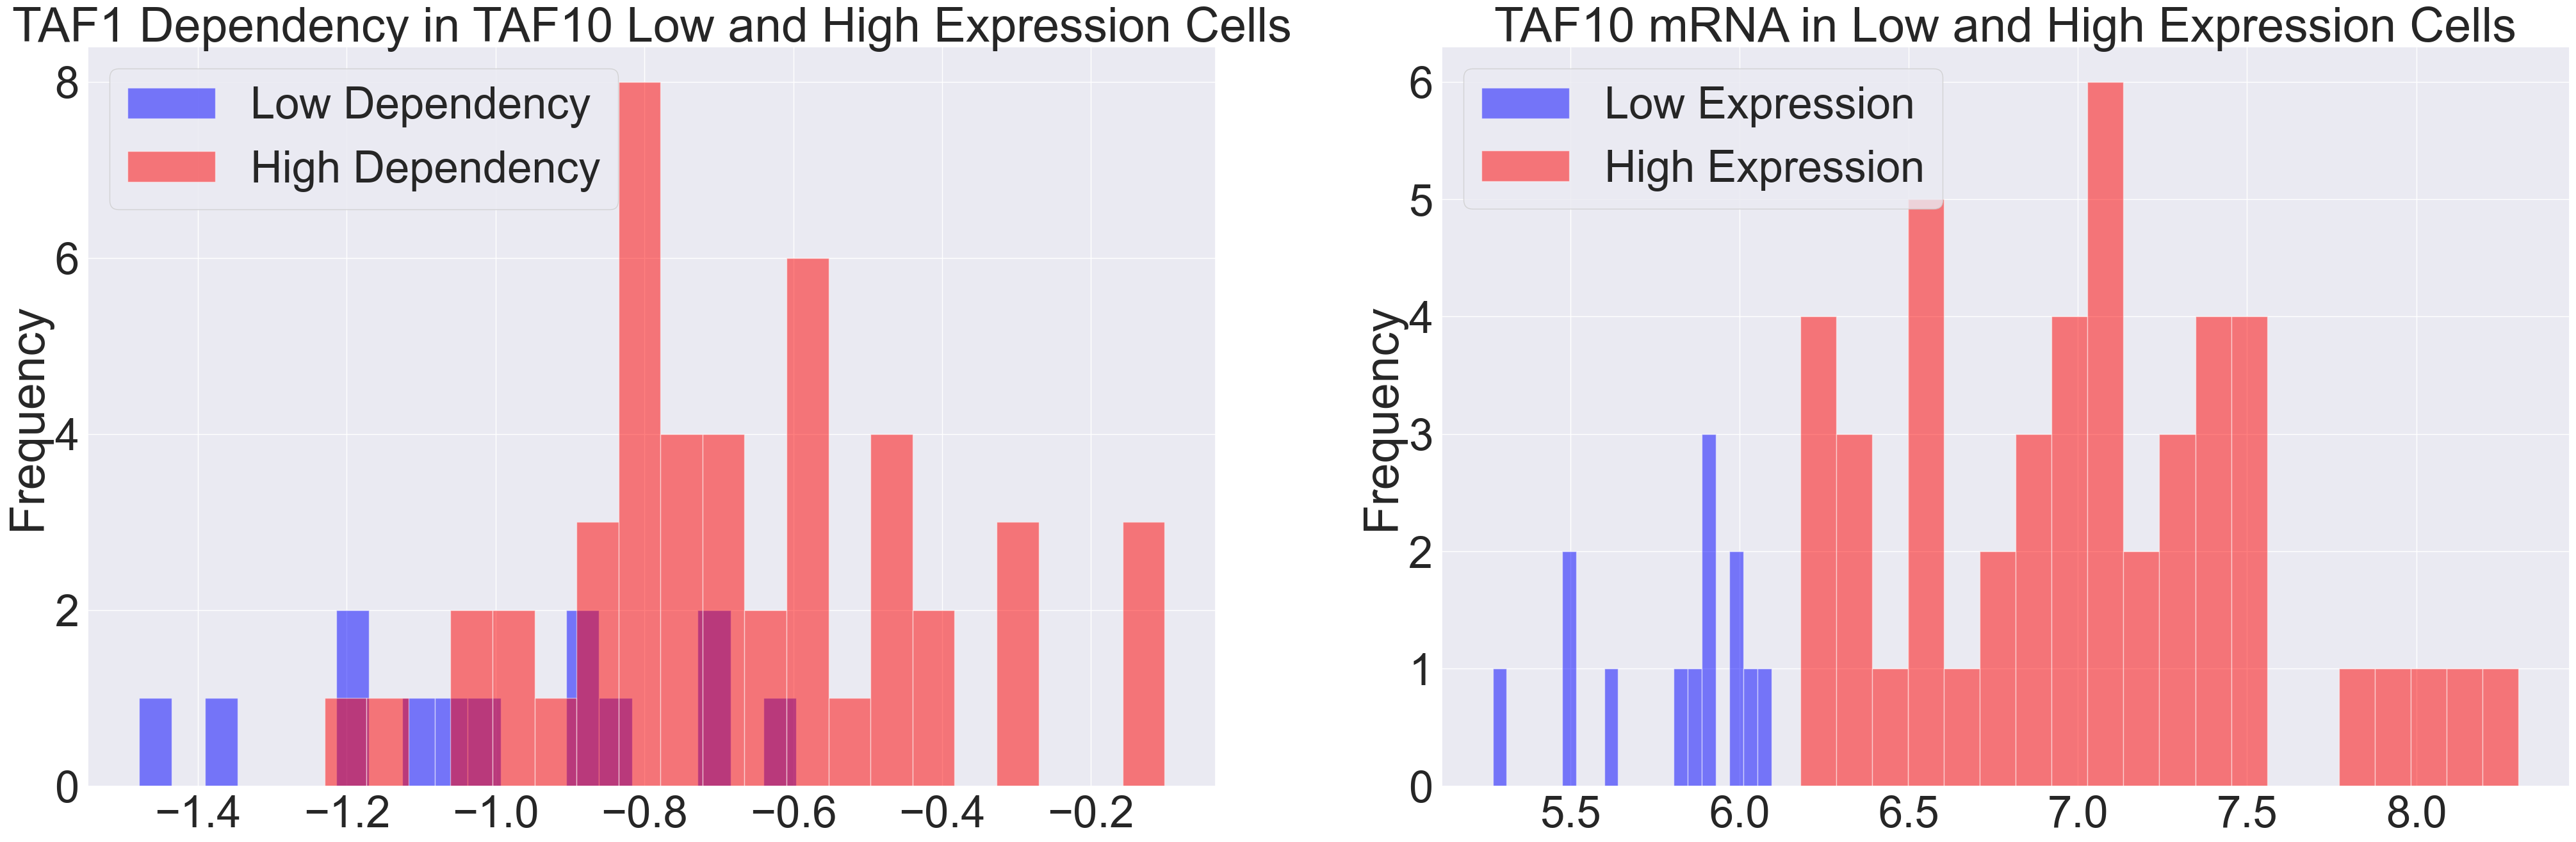

In [85]:
# Manual Validation
gene = 'TAF10'
gene2 = 'TAF1'
low_expression = gene_groups[gene_groups[gene] == 'low'].index
high_expression = gene_groups[gene_groups[gene] == 'high'].index


low_expression_dependency = dependency_df.loc[low_expression, gene2]
high_expression_dependency = dependency_df.loc[high_expression, gene2]


# T-Test of Gene Dependency in Low and High Expression Cells
ttest = stats.ttest_ind(low_expression_dependency, high_expression_dependency,  alternative = 'two-sided')

# Add the t-statistic to the gene effect matrix
significant_rows_df[vip_genes[vip_genes == gene].index[0], vip_genes[vip_genes == gene2].index[0]] = ttest[0]

fig,ax = plt.subplots(1,2,figsize=(50,15))

ax[0].hist(low_expression_dependency, bins=20, color='blue', alpha=0.5, label='Low Dependency')
ax[0].hist(high_expression_dependency, bins=20, color='red', alpha=0.5, label='High Dependency')
ax[0].legend(loc='upper left')
ax[0].set_ylabel('Frequency')
ax[0].set_title(gene2 + ' Dependency in ' + gene + ' Low and High Expression Cells')

# mRNA
ax[1].hist(mRNA_df.loc[low_expression, gene], bins=20, color='blue', alpha=0.5, label='Low Expression')
ax[1].hist(mRNA_df.loc[high_expression, gene], bins=20, color='red', alpha=0.5, label='High Expression')
ax[1].legend(loc='upper left')
ax[1].set_ylabel('Frequency')
ax[1].set_title(gene + ' mRNA in Low and High Expression Cells')


print(low_expression.shape)
print(high_expression.shape)
print(low_expression_dependency.shape)
print(high_expression_dependency.shape)
    